In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
三阶贝塞尔曲线
输入:
    p0, p1, p2, p3 为 点坐标,tuple、list或numpy.ndarray类型
    inserted 为 p0和p3之间插值的数量
"""
def bezier_curve(p0, p1, p2, p3, inserted):
    
    assert isinstance(p0, (tuple, list, np.ndarray))
    assert isinstance(p0, (tuple, list, np.ndarray))
    assert isinstance(p0, (tuple, list, np.ndarray))
    assert isinstance(p0, (tuple, list, np.ndarray))

    if isinstance(p0, (tuple, list)):
        p0 = np.array(p0)
    if isinstance(p1, (tuple, list)):
        p1 = np.array(p1)
    if isinstance(p2, (tuple, list)):
        p2 = np.array(p2)
    if isinstance(p3, (tuple, list)):
        p3 = np.array(p3)

    points = list()
    for t in np.linspace(0, 1, inserted + 2):
        # 三阶贝塞尔曲线计算公式
        points.append(p0 * np.power((1 - t), 3) + 3 * p1 * t * np.power((1 - t), 2) + 3 * p2 * (1 - t) * np.power(t, 2) + p3 * np.power(t, 3))

    return np.vstack(points)

In [15]:
"""
基于三阶贝塞尔曲线的数据平滑算法
输入:
    date_x 为 x维度数据集,list或numpy.ndarray类型
    date_y 为 y维度数据集,list或numpy.ndarray类型
    k 为 调整平滑曲线形状的因子,取值一般在0.2~0.6之间。默认值为0.5
    inserted 为 两个原始数据点之间插值的数量。默认值为50
    closed 为 曲线是否封闭,如是,则首尾相连。默认曲线不封闭
"""
def smoothing_base_bezier(date_x, date_y, k=0.5, inserted=100, closed=False):

    assert isinstance(date_x, (list, np.ndarray))
    assert isinstance(date_y, (list, np.ndarray))

    if isinstance(date_x, list) and isinstance(date_y, list):
        assert len(date_x) == len(date_y), u'x数据集和y数据集长度不匹配'
        date_x = np.array(date_x)
        date_y = np.array(date_y)
    elif isinstance(date_x, np.ndarray) and isinstance(date_y, np.ndarray):
        assert date_x.shape == date_y.shape, u'x数据集和y数据集长度不匹配'
    else:
        raise Exception(u'x数据集或y数据集类型错误')

    # 第1步：生成原始数据折线中点集
    mid_points = list()
    for i in range(1, date_x.shape[0]):
        mid_points.append({
            'start': (date_x[i - 1], date_y[i - 1]),
            'end': (date_x[i], date_y[i]),
            'mid': ((date_x[i] + date_x[i - 1]) / 2.0, (date_y[i] + date_y[i - 1]) / 2.0)
        })

    if closed:
        mid_points.append({
            'start': (date_x[-1], date_y[-1]),
            'end': (date_x[0], date_y[0]),
            'mid': ((date_x[0] + date_x[-1]) / 2.0, (date_y[0] + date_y[-1]) / 2.0)
        })

    # 第2步：找出中点连线及其分割点
    split_points = list()
    for i in range(len(mid_points)):
        if i < (len(mid_points) - 1):
            j = i + 1
        elif closed:
            j = 0
        else:
            continue

        x00, y00 = mid_points[i]['start']
        x01, y01 = mid_points[i]['end']
        x10, y10 = mid_points[j]['start']
        x11, y11 = mid_points[j]['end']
        d0 = np.sqrt(np.power((x00 - x01), 2) + np.power((y00 - y01), 2))
        d1 = np.sqrt(np.power((x10 - x11), 2) + np.power((y10 - y11), 2))
        k_split = 1.0 * d0 / (d0 + d1)

        mx0, my0 = mid_points[i]['mid']
        mx1, my1 = mid_points[j]['mid']

        split_points.append({
            'start': (mx0, my0),
            'end': (mx1, my1),
            'split': (mx0 + (mx1 - mx0) * k_split, my0 + (my1 - my0) * k_split)
        })

    # 第3步：平移中点连线，调整端点，生成控制点
    crt_points = list()
    for i in range(len(split_points)):
        vx, vy = mid_points[i]['end']  # 当前顶点的坐标
        dx = vx - split_points[i]['split'][0]  # 平移线段x偏移量
        dy = vy - split_points[i]['split'][1]  # 平移线段y偏移量

        sx, sy = split_points[i]['start'][0] + dx, split_points[i]['start'][1] + dy  # 平移后线段起点坐标
        ex, ey = split_points[i]['end'][0] + dx, split_points[i]['end'][1] + dy  # 平移后线段终点坐标

        cp0 = sx + (vx - sx) * k, sy + (vy - sy) * k  # 控制点坐标
        cp1 = ex + (vx - ex) * k, ey + (vy - ey) * k  # 控制点坐标

        if crt_points:
            crt_points[-1].insert(2, cp0)
        else:
            crt_points.append([mid_points[0]['start'], cp0, mid_points[0]['end']])

        if closed:
            if i < (len(mid_points) - 1):
                crt_points.append([mid_points[i + 1]['start'], cp1, mid_points[i + 1]['end']])
            else:
                crt_points[0].insert(1, cp1)
        else:
            if i < (len(mid_points) - 2):
                crt_points.append([mid_points[i + 1]['start'], cp1, mid_points[i + 1]['end']])
            else:
                crt_points.append([mid_points[i + 1]['start'], cp1, mid_points[i + 1]['end'], mid_points[i + 1]['end']])
                crt_points[0].insert(1, mid_points[0]['start'])

    # 第4步：应用贝塞尔曲线方程插值
    out = list()
    for item in crt_points:
        group = bezier_curve(item[0], item[1], item[2], item[3], inserted)
        out.append(group[:-1])

    out.append(group[-1:])
    out = np.vstack(out)

    return out.T[0], out.T[1]

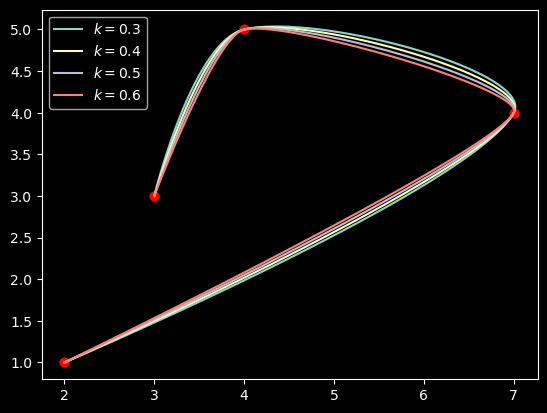

In [47]:
if __name__ == '__main__':
    x = np.array([2, 7, 4, 3])
    y = np.array([1, 4, 5, 3])

    plt.plot(x, y, 'ro')
    x_curve, y_curve = smoothing_base_bezier(x, y, k=0.3, closed=True)

    k = []
    
    
    
    
    
    
    # plt.plot(x_curve, y_curve, label='$k=0.3$')
    # x_curve, y_curve = smoothing_base_bezier(x, y, k=0.4, closed=True)
    # plt.plot(x_curve, y_curve, label='$k=0.4$')
    # x_curve, y_curve = smoothing_base_bezier(x, y, k=0.5, closed=True)
    # plt.plot(x_curve, y_curve, label='$k=0.5$')
    # x_curve, y_curve = smoothing_base_bezier(x, y, k=0.6, closed=True)
    # plt.plot(x_curve, y_curve, label='$k=0.6$')
    # plt.legend(loc='best')
    # plt.show()
    
    plt.plot(x, y, 'ro')
    x_curve, y_curve = smoothing_base_bezier(x, y, k=0.3)
    plt.plot(x_curve, y_curve, label='$k=0.3$')
    x_curve, y_curve = smoothing_base_bezier(x, y, k=0.4)
    plt.plot(x_curve, y_curve, label='$k=0.4$')
    x_curve, y_curve = smoothing_base_bezier(x, y, k=0.5)
    plt.plot(x_curve, y_curve, label='$k=0.5$')
    x_curve, y_curve = smoothing_base_bezier(x, y, k=0.6)
    plt.plot(x_curve, y_curve, label='$k=0.6$')
    plt.legend(loc='best')
    plt.show()